# Accessing an APOGEE Spectrum with sdss-access

## Learning Goals
By the end of this tutorial, you will:
- Understand how to retrieve SDSS data with sdss-access
- Understand some of the structure of a fits file containing an APOGEE spectrum
- (Optionally) have a copy of the AllStarASPCAP file

## Introduction
The Apache Point Observatory Galactic Evolution Experiment (APOGEE) is an infrared spectroscopic survey using two spectrographs at the two SDSS V observatories, Apache Point Observatory (APO) and Las Campanas Observatory (LCO).

In this short tutorial we will briefly cover how to retrieve an object's sdss_id from the allStarASPCAP file, then show how to use the sdss-access tool to retreive the APOGEE spectrum of that star from the SDSS Science Archive Server (SAS).

## Imports
This tutorial requires two commonly used python packages, and an SDSS specific package
- _matplotlib_ for plotting
- _astropy_ for reading fits table
- _sdss-access_ for accessing data on the SAS

Missing packages can be installed via `pip install matplotlib astropy sdss-access` 

NOTE: You may want to set the `$SAS_BASE_DIR` environment variable before starting this notebook, other wise `$HOME/sas` will be created and used

In [1]:
import matplotlib.pyplot as plt
from astropy.table import Table

from sdss_access import Access
access = Access(release='dr19')

## Optional Download

If you have good internet access and space on your computer, you may download the summary file for ASPCAP. It is approximately 1.1 GB in size and can be downloaded from 
https://data.sdss5.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz

`file_name` is currently set to just the name of the file. If the file is not in the same location as this notebook, you may need to change the variable to point to the full path

If you prefer to use a previously chosen example object, skip the next two cells.

HDU 2 contains the parameters from APOGEE north (APO) spectra. The current data release does not have LCO spectra.

### SciServer

If you are running this notebook on SciServer, this file is already available. Uncomment the second `file_name` variable to use that file.

In [ ]:
file_name = "astraAllStarASPCAP-0.6.0.fits.gz"

# file_name = "/home/idies/workspace/sdss_sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz"

allStarASPCAP = Table.read(file_name, hdu=2)
len(allStarASPCAP)

1095480

In [3]:
single_star = allStarASPCAP[1]
sdss_id = single_star["sdss_id"]
sdss_id

85993595

For anyone who did not download the allStar summary file, we'll set sdss_id explicitly

In [4]:
sdss_id = 85993595

## sdss-access

sdss-access has extensive [documentation](https://sdss-access.readthedocs.io/en/latest/), but we should mention a few things. First if you are a member of the collaboration accessing proprietary data, you need to set up a a [.netrc file](https://sdss-access.readthedocs.io/en/latest/auth.html). After that usage is the same for everyone.

You need specify the file species you need, in this case 'mwmStar', then a series of key word arguments that vary depending on the file species. A list of file species and their keyword arugments is [available](https://sdss-access.readthedocs.io/en/latest/paths.html).

The four lines of code below show an example of retreiving an sdss spectrum. `access.commit()` will retrieve the file and save it to your local SAS, `$SAS_BASE_DIR`, with the same structure as the SAS (so it will be many files deep)

### SciServer

If you are running this notebook on SciServer, the next cell may fail, but it is not needed. The data are all already avaible, so skip this cell and move to the next where we'll verify the file we need is present.

In [5]:
access.remote()
access.add('mwmStar', v_astra='0.6.0', component='', sdss_id=sdss_id)
access.set_stream()
access.commit()

Progress:   0%|                | 0/1 [00:00<?, ?files/s, n_files=1, n_streams=1]

SDSS_ACCESS> Done!


Now we'll separately build the path to our spectrum using `access.full`, print to see it on disk, then check that the file is there

In [6]:
mwmStar_filename = access.full('mwmStar', v_astra='0.6.0', component='', sdss_id=sdss_id)
print(mwmStar_filename)
access.exists('', full=mwmStar_filename)

/Users/jdonor/sas/dr19/spectro/astra/0.6.0/spectra/star/35/95/mwmStar-0.6.0-85993595.fits


True

## Load the spectrum

Now use `astropy.Table` load the data. HDU 3 contains the APO spectrum.

We then extract wavelength, flux, and ivar (inverse variance) to more convenient variables. Not we need the `[0]` entry. This is part of the file structure meant to be as similar as possible to other file species, which contain separat espectra for each visit. 

$ivar^{1/2}$ is a good representation of uncertainty in the flux

In [7]:
mwmStar = Table.read(mwmStar_filename, hdu=3)

obs_wl = mwmStar["wavelength"][0]
obs_flux = mwmStar["flux"][0]
obs_err = mwmStar["ivar"][0]**(-0.5)

[WARNING]: /var/folders/nd/01s30xjn2z1_lx_f3bqdbwt4nm074c/T/ipykernel_54888/3069109418.py:5: RuntimeWarning: divide by zero encountered in power
  obs_err = mwmStar["ivar"][0]**(-0.5)



Now plot the spectrum, flux vs wavelength.

Note the mask.

Text(0, 0.5, 'flux')

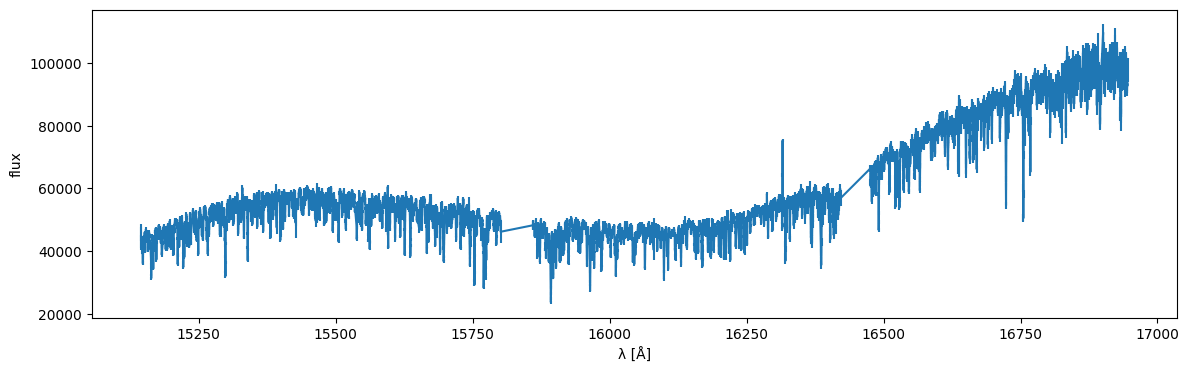

In [8]:
plt.figure(figsize=(14,4))

mask = obs_err < 0.1 * obs_flux

plt.errorbar(obs_wl[mask], obs_flux[mask], yerr=obs_err[mask])
plt.xlabel("λ [Å]")
plt.ylabel("flux")

### About this notebook

This notebook was created to give an example of using the `sdss-access` tool, and illustrate how to use an APOGEE spectrum.

**Authors**: Adam Wheeler, John Donor

**Last Update**: 2025 April 2

If you use `astropy`  for published research, please cite the
authors. Follow this link for more information about citing `astropy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

And of course please [cite](https://sdss.org/collaboration/citing-sdss/) SDSS when you use our data.